In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys, os, sys, math
from pathlib import Path
import matplotlib.pyplot as plt, numpy as np
from jfi import jaxm

root_path = Path("").absolute().parent
if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))
import pmpc
from dubins_car import f_np as f_fn, fx_np as fx_fn, fu_np as fu_fn
import jaxopt
from pmpc.experimental import scp_solve, solve_problems
from pmpc.experimental.second_order_solvers import ConvexSolver, positive_cholesky_factorization
print(jaxm.zeros(()).dtype)
print(jaxm.zeros(()).device())

float64
TFRT_CPU_0


In [3]:
U, S, _ = jaxm.linalg.svd(jaxm.ones((100, 100)))
H1 = U @ jaxm.diag(S) @ U.T
S = S.at[-1].set(-1e5)
H2 = U @ jaxm.diag(S) @ U.T

F1 = positive_cholesky_factorization(H1)
F2 = positive_cholesky_factorization(H2)

In [4]:
def car(x, u, p):
    """
    unicycle car dynamics, 4 states, 2 actions
    x1: position x
    x2: position y
    x3: speed (local frame)
    x4: orientation angle

    u1: acceleration
    u2: turning speed (independent of velocity)
    """
    assert x.shape[-1] == 4 and u.shape[-1] == 2
    v_scale, w_scale, T = p[..., 0], p[..., 1], p[..., 2]
    eps = 1e-6
    u1, u2 = v_scale * u[..., 0], w_scale * -u[..., 1]
    u1 = u1 + jaxm.where(u1 >= 0.0, eps, -eps)
    u2 = u2 + jaxm.where(u2 >= 0.0, eps, -eps)

    x0, y0, v0, th0 = x[..., 0], x[..., 1], x[..., 2], x[..., 3]
    xp1 = (
        x0
        + (
            u2 * jaxm.sin(T * u2 + th0) * v0
            + T * u1 * u2 * jaxm.sin(T * u2 + th0)
            + u1 * jaxm.cos(T * u2 + th0)
        )
        / u2 ** 2
        - (jaxm.sin(th0) * u2 * v0 + jaxm.cos(th0) * u1) / u2 ** 2
    )
    xp2 = (
        y0
        - (
            u2 * jaxm.cos(T * u2 + th0) * v0
            - u1 * jaxm.sin(T * u2 + th0)
            + T * u1 * u2 * jaxm.cos(T * u2 + th0)
        )
        / u2 ** 2
        + (jaxm.cos(th0) * u2 * v0 - jaxm.sin(th0) * u1) / u2 ** 2
    )
    xp3 = v0 + T * u1
    xp4 = T * u2 + th0
    xp = jaxm.stack([xp1, xp2, xp3, xp4], -1)
    return xp

def fx_(x, u, p):
    sum_dims = range(0, x.ndim - 1)
    return jaxm.moveaxis(jaxm.jacobian(lambda x: jaxm.sum(car(x, u, p), sum_dims))(x), 0, -2)

def fu_(x, u, p):
    sum_dims = range(0, x.ndim - 1)
    return jaxm.moveaxis(jaxm.jacobian(lambda u: jaxm.sum(car(x, u, p), sum_dims))(u), 0, -2)

@jaxm.jit
def f_fx_fu_fn_(x, u):
    p = jaxm.to(jaxm.array([1.0, 1.0, 0.3]), dtype=x.dtype)
    return car(x, u, p), fx_(x, u, p), fu_(x, u, p)

In [5]:
def f_fx_fu_fn(X_prev, U_prev):
    X_prev, U_prev = np.array(X_prev), np.array(U_prev)
    x, u, p = X_prev, U_prev, np.array([1.0, 1.0, 0.3])
    return f_fn(x, u, p), fx_fn(x, u, p), fu_fn(x, u, p)

In [12]:
M, N, xdim, udim = 1000, 20, 4, 2

Q = np.tile(np.eye(xdim), (N, 1, 1))
R = np.tile(1e-2 * np.eye(udim), (N, 1, 1))
x0 = np.tile(np.ones(xdim), (1,))
X_ref, U_ref = np.zeros((N, xdim)), np.zeros((N, udim))
X_prev, U_prev = np.zeros((N, xdim)), np.zeros((N, udim))
u_lim = 1.0
u_l, u_u = -u_lim * np.ones((N, udim)), u_lim * np.ones((N, udim))

Q, R, x0, X_ref, U_ref, X_prev, U_prev, u_l, u_u = [
    np.tile(z, (M,) + (1,) * z.ndim) for z in [Q, R, x0, X_ref, U_ref, X_prev, U_prev, u_l, u_u]
]

opts = dict(verbose=True, u_l=u_l, u_u=u_u, reg_x=5e0, reg_u=1e0)
args = (f_fx_fu_fn, Q, R, x0, X_ref, U_ref, X_prev, U_prev)
solver_settings = dict(smooth_alpha=1e3, solver="CVX")


def extra_cvx_cost_fn(*args, **kw):
    return 0.0


problems = [
    dict(
        f_fx_fu_fn=f_fx_fu_fn,
        Q=Q[i],
        R=R[i],
        x0=x0[i],
        X_ref=X_ref[i],
        U_ref=U_ref[i],
        X_prev=X_prev[i],
        U_prev=U_prev[i],
        u_l=u_l[i],
        u_u=u_u[i],
        reg_x=opts["reg_x"],
        reg_u=opts["reg_u"],
        solver_settings=solver_settings,
        verbose=True,
        max_it=10,
        extra_cvx_cost_fn=extra_cvx_cost_fn,
    )
    for i in range(Q.shape[0])
]

In [18]:
X, U, data = scp_solve(
    f_fx_fu_fn_,
    *args[1:],
    max_it=50,
    res_tol=1e-12,
    **opts,
    #solver_settings=dict(smooth_alpha=1e0, solver="BFGS", linesearch="backtracking", maxls=50),
    #solver_settings=dict(smooth_alpha=1e3, solver="SQP", maxls=25, linesearch="scan"),
    solver_settings=dict(smooth_alpha=1e2),
    device="cuda",
    jse_differentiable_dynamics=False,
    diff_rollout=True,
)

+------+------------+------------+------------+----------+----------+----------+
|  it  |   elaps    |    obj     |   resid    |  reg_x   |  reg_u   |  alpha   |
+------+------------+------------+------------+----------+----------+----------+
| 0001 |  2.128e-01 |  5.582e-01 |  1.419e+00 |  5.0e+00 |  1.0e+00 |  1.0e+02 |
| 0002 |  4.126e-01 |  9.379e-02 |  1.003e+00 |  5.0e+00 |  1.0e+00 |  1.0e+02 |
| 0003 |  6.199e-01 |  6.242e+00 |  1.749e+00 |  5.0e+00 |  1.0e+00 |  1.0e+02 |
| 0004 |  8.185e-01 |  1.010e+00 |  2.686e-01 |  5.0e+00 |  1.0e+00 |  1.0e+02 |
| 0005 |  1.018e+00 |  8.807e-01 |  1.226e-01 |  5.0e+00 |  1.0e+00 |  1.0e+02 |
| 0006 |  1.224e+00 |  8.386e-01 |  1.225e-01 |  5.0e+00 |  1.0e+00 |  1.0e+02 |
| 0007 |  1.424e+00 |  8.091e-01 |  1.268e-01 |  5.0e+00 |  1.0e+00 |  1.0e+02 |
| 0008 |  1.624e+00 |  7.880e-01 |  1.223e-01 |  5.0e+00 |  1.0e+00 |  1.0e+02 |
| 0009 |  1.829e+00 |  7.727e-01 |  1.160e-01 |  5.0e+00 |  1.0e+00 |  1.0e+02 |
| 0010 |  2.028e+00 |  7.615

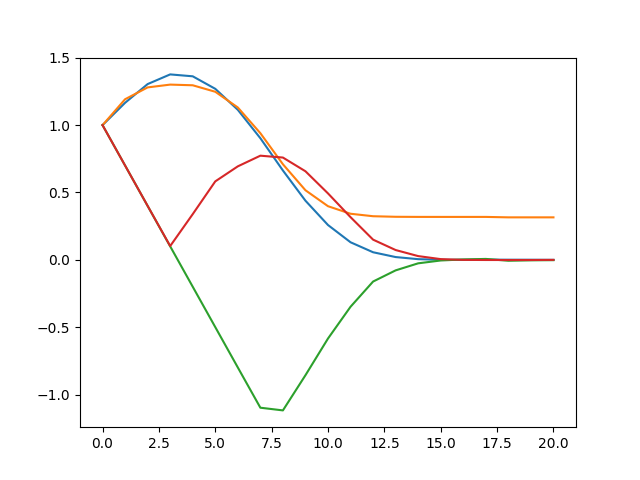

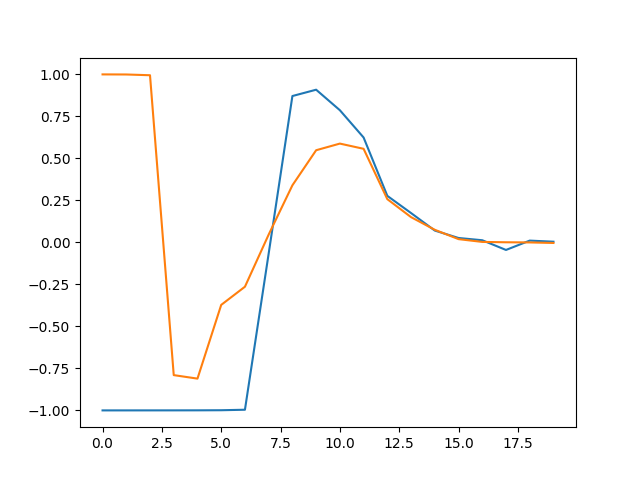

In [16]:
idx = 2
plt.figure(4356675)
plt.clf()
for r in range(X.shape[-1]):
    plt.plot(X[idx, :, r], label=f"x{r}")
plt.show()
plt.figure(4534534)
plt.clf()
for r in range(U.shape[-1]):
    plt.plot(U[idx, :, r], label=f"u{r}")
plt.show()

# Solve using the alternative interface

In [ ]:
from line_profiler import LineProfiler

LP = LineProfiler()
LP.add_function(solve_problems)
sols = LP.wrap_function(solve_problems)(problems)
LP.print_stats(output_unit=1e-3)

LP = LineProfiler()
LP.add_function(solve_problems)
sols = LP.wrap_function(solve_problems)(problems, split=True)
LP.print_stats(output_unit=1e-3)

# CPU version

In [31]:
opts["solver_settings"] = dict(solver="ecos", smooth_alpha=1e3, smooth_cstr="logbarrier")
X2, U2, data = pmpc.solve(
    *[arg[0] if hasattr(arg, "shape") else arg for arg in list(args)[:-2] + [X[..., 1:, :], U]],
    max_it=50,
    **dict(opts, reg_x=1e1),
)

+------+------------+------------+------------+------------+------------+
|  it  |   elaps    |    obj     |   resid    |   reg_x    |   reg_u    |
+------+------------+------------+------------+------------+------------+
| 0001 |  2.429e+01 |  1.617e+00 |  7.429e-03 |  1.000e+01 |  1.000e+00 |
| 0002 |  2.430e+01 |  1.617e+00 |  4.173e-03 |  1.000e+01 |  1.000e+00 |
| 0003 |  2.430e+01 |  1.617e+00 |  3.943e-03 |  1.000e+01 |  1.000e+00 |
| 0004 |  2.431e+01 |  1.617e+00 |  3.748e-03 |  1.000e+01 |  1.000e+00 |
| 0005 |  2.432e+01 |  1.617e+00 |  3.566e-03 |  1.000e+01 |  1.000e+00 |
| 0006 |  2.433e+01 |  1.617e+00 |  3.394e-03 |  1.000e+01 |  1.000e+00 |
| 0007 |  2.433e+01 |  1.617e+00 |  3.231e-03 |  1.000e+01 |  1.000e+00 |
| 0008 |  2.434e+01 |  1.617e+00 |  3.076e-03 |  1.000e+01 |  1.000e+00 |
| 0009 |  2.435e+01 |  1.617e+00 |  2.929e-03 |  1.000e+01 |  1.000e+00 |
| 0010 |  2.435e+01 |  1.617e+00 |  2.794e-03 |  1.000e+01 |  1.000e+00 |
| 0011 |  2.436e+01 |  1.617e+00 |  2.

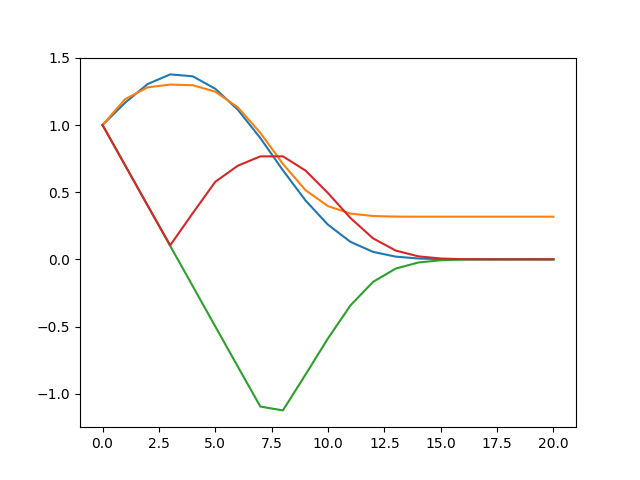

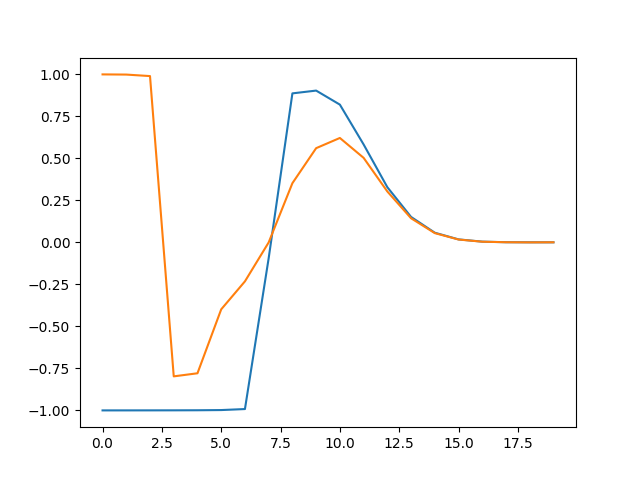

In [33]:
plt.figure(663454475)
plt.clf()
for r in range(X2.shape[1]):
    plt.plot(X2[:, r], label=f"x{r}")
plt.show()
plt.figure(45435534)
plt.clf()
for r in range(U2.shape[1]):
    plt.plot(U2[:, r], label=f"u{r}")
plt.show()

# simple QP test case

In [ ]:
P, q = jaxm.randn((100, 100)), jaxm.randn((100,))
P = P @ P.T

def obj_fn(x):
    J = jaxm.sum(x * (P @ x)) / 2 + jaxm.sum(q * x) + jaxm.sum(-jaxm.log(x))
    J = jaxm.where(jaxm.any(x < 0.0), jaxm.inf, J)
    return J
#print(f"best_loss = {obj_fn(jaxm.linalg.solve(P, -q))}")
solver = ConvexSolver(obj_fn, jit=True, maxiter=100, tol=1e-3, linesearch="binary_search", maxls=20)
params = jaxm.ones((100,))
state = solver.init_state(params)
for it in range(10):
    params, state = solver.update(params, state)
    print(f"{jaxm.norm(params), state.best_loss}")
print()
solver = ConvexSolver(obj_fn, jit=True, maxiter=100, tol=1e-3, linesearch="scan", maxls=20)
params = jaxm.ones((100,))
state = solver.init_state(params)
for it in range(10):
    params, state = solver.update(params, state)
    print(f"{jaxm.norm(params), state.best_loss}")